In [1]:
# # Pytorch Cuda 오류발생시 해당 코드를 활성화하여
# # 좀더 자세한 오류 원인을 찾자!
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'    # CUDA 커널 호출을 동기화
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"    # 0번 GPU에서만 연산을 수행하게 강제
# os.environ["TORCH_USE_CUDA_DSA"] = '1'      # CUDA 커널 내부에서 assert 구문 적용

## 내가 설계한 Yolo v3모델의 학습/평가 수행

참고사항 : Backbone 만 pretrained model

In [2]:
import torch
import darknet53_FPN as darknet53 #백본 모델 구성정보
from Yolov3_model import YOLOv3, FPN, debug # 나머지 모델레이어 구성정보
from yolo_dataset import CustomDataset #커스텀 데이터셋 코드

from yolo_v3_loss import Yolov3Loss, loss_debug #Loss 함수 코드
from yolo_v3_metrics import YOLOv3Metrics, metrics_debug #평가지표 코드
from ModelTrainer import ModelTrainer #train / val 코드
import coco_data # 전역변수 모음집

In [3]:
# 모델 초기화(backbone는 사전학습모델 로드)
backbone = darknet53.Darknet53(pretrained=True)
fpn = FPN(channels_list=coco_data.fpn_in_ch)
yolov3 = YOLOv3(backbone, fpn, num_classes=80)

In [4]:
# 백본 파라미터 Freeze
for param in backbone.parameters():
    param.requires_grad = False

In [5]:
# coco데이터셋의 메인 루트 디렉토리
root_dir = './../00_pytest_img/COCO dataset'

# load_anno=val2014 -> 'instance_val2014.json'참조 + `val2014`img폴더 참조
train_dataset = CustomDataset(root=root_dir, load_anno='train2017', 
                              anchor=coco_data.anchor_box_list)
test_dataset = CustomDataset(root=root_dir, load_anno='val2017', 
                             anchor=coco_data.anchor_box_list)

print(f"훈련용 : {train_dataset}, \n 검증용 : {test_dataset}")

loading annotations into memory...
Done (t=12.29s)
creating index...
index created!
loading annotations into memory...
Done (t=0.39s)
creating index...
index created!
훈련용 : Img 폴더 찾은 *.jpg 개수: 118287, 
 검증용 : Img 폴더 찾은 *.jpg 개수: 5000


In [6]:
from torchvision.transforms import v2

coco_val = [[0.4701, 0.4468, 0.4076], [0.2379, 0.2329, 0.2362]]
# 데이터셋 전처리 방법론 정의
transforamtion = v2.Compose([
    v2.Resize((416, 416)), #이미지 크기를 416, 416로
    v2.ToImage(),  # 이미지를 Tensor 자료형으로 변환
    v2.ToDtype(torch.float32, scale=True), #텐서 자료형을 [0~1]로 스케일링
    v2.Normalize(mean=coco_val[0], std=coco_val[1]) #데이터셋 정규화
])

In [7]:
# 데이터셋 전처리 방법론 적용
train_dataset.transform = transforamtion
test_dataset.transform = transforamtion

In [8]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128
# 전처리가 완료된 데이터셋의 데이터로더 전환
train_loader = DataLoader(train_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
test_loader = DataLoader(test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 앞서 선언한 모델의 GPU이전
backbone.to(device)
fpn.to(device)
yolov3.to(device)
print()

In [10]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

# 손실 함수 설정 (YOLOv3 손실 함수)
# 여기서 cho_mode=True 이면 예측 값을 필터링해서 IOU값으로 Localization Loss연산 수행
# cho_mode=False 이면 기존 방식으로 모든 예측값에 대하여 Localization Loss연산 수행
criterion = Yolov3Loss(device=device.type, cho_mode=False, 
                       anchor=coco_data.anchor_box_list)

# 옵티마이저 설정 (프리즈되지 않은 파라미터만)
optimizer = AdamW(filter(lambda p: p.requires_grad, yolov3.parameters()), lr=1e-4, weight_decay=1e-4)
# 스케줄러 설정 (50 에폭 기준 Cosine Annealing)
scheduler = CosineAnnealingLR(optimizer, T_max=40)

In [11]:
# Train / eval(Val) 및 평가지표 코드 인스턴스화
epoch_step = 3
trainer = ModelTrainer(epoch_step=epoch_step, device=device.type)
metrics = YOLOv3Metrics(anchor=coco_data.anchor_box_list, device=device.type)

In [12]:
# 학습과 검증 손실 및 정확도를 저장할 리스트
his_loss = []
his_KPI = []
num_epoch = 30

for epoch in range(num_epoch):
    # 훈련 손실과 훈련 성과지표를 반환 받습니다.
    train_loss, train_KPI = trainer.model_train(yolov3, train_loader, 
                                                criterion, optimizer, scheduler,
                                                metrics, epoch)

    # 검증 손실과 검증 성과지표를 반환 받습니다.
    test_loss, test_KPI = trainer.model_evaluate(yolov3, test_loader, 
                                                 criterion, metrics, epoch)

    # 손실과 성능지표를 리스트에 저장
    his_loss.append((train_loss, test_loss))
    his_KPI.append((train_KPI, test_KPI))

    # epoch가 특정 배수일 때만 출력하기
    if (epoch + 1) % epoch_step == 0 or epoch == 0:
        print(f"epoch {epoch+1:03d}," + "\t" + 
              f"훈련 loss: {train_loss:.4f}")
        print(f"훈련 KPI[ IOU: {train_KPI[0]:.4f}, "+
              f"mAP: {train_KPI[1]:.4f}, "+
              f"Recall: {train_KPI[2]:.4f}, "+ 
              f"Top1_err: {train_KPI[3]:.4f} ]")
        print(f"epoch {epoch+1:03d}," + "\t" + 
              f"검증 loss: {test_loss:.4f}")
        print(f"검증 KPI[ IOU: {test_KPI[0]:.4f}, "+
              f"mAP: {test_KPI[1]:.4f}, "+
              f"Recall: {test_KPI[2]:.4f}, "+
              f"Top1_err: {test_KPI[3]:.4f} ]")

[훈련중] Loss: 228865.69, KPI: [0.402, 0.011, 0.114, 0.687]: 100%|██████████| 925/925 [42:27<00:00,  2.75s/it]
100%|██████████| 40/40 [01:41<00:00,  2.54s/it]


epoch 001,	훈련 loss: 228865.6904
훈련 KPI[ IOU: 0.4024, mAP: 0.0113, Recall: 0.1144, Top1_err: 0.6865 ]
epoch 001,	검증 loss: 133335.7863
검증 KPI[ IOU: 0.3699, mAP: 0.0148, Recall: 0.1121, Top1_err: 0.6109 ]


[훈련중] Loss: 80905.94, KPI: [0.459, 0.034, 0.228, 0.497]: 100%|██████████| 925/925 [42:19<00:00,  2.75s/it]
100%|██████████| 40/40 [01:41<00:00,  2.53s/it]


epoch 003,	훈련 loss: 80905.9387
훈련 KPI[ IOU: 0.4591, mAP: 0.0343, Recall: 0.2280, Top1_err: 0.4972 ]
epoch 003,	검증 loss: 93859.2651
검증 KPI[ IOU: 0.3935, mAP: 0.0256, Recall: 0.1440, Top1_err: 0.4777 ]


[훈련중] Loss: 61795.12, KPI: [0.487, 0.049, 0.270, 0.345]: 100%|██████████| 925/925 [44:09<00:00,  2.86s/it]
100%|██████████| 40/40 [01:41<00:00,  2.54s/it]


epoch 006,	훈련 loss: 61795.1220
훈련 KPI[ IOU: 0.4869, mAP: 0.0489, Recall: 0.2703, Top1_err: 0.3454 ]
epoch 006,	검증 loss: 85605.7425
검증 KPI[ IOU: 0.3989, mAP: 0.0322, Recall: 0.1533, Top1_err: 0.3578 ]


[훈련중] Loss: 51587.06, KPI: [0.511, 0.062, 0.304, 0.277]: 100%|██████████| 925/925 [42:33<00:00,  2.76s/it]
100%|██████████| 40/40 [01:41<00:00,  2.55s/it]


epoch 009,	훈련 loss: 51587.0644
훈련 KPI[ IOU: 0.5115, mAP: 0.0623, Recall: 0.3037, Top1_err: 0.2770 ]
epoch 009,	검증 loss: 92509.5010
검증 KPI[ IOU: 0.3879, mAP: 0.0357, Recall: 0.1539, Top1_err: 0.3241 ]


[훈련중] Loss: 45324.70, KPI: [0.530, 0.075, 0.331, 0.238]: 100%|██████████| 925/925 [42:38<00:00,  2.77s/it]
100%|██████████| 40/40 [01:41<00:00,  2.54s/it]


epoch 012,	훈련 loss: 45324.7021
훈련 KPI[ IOU: 0.5298, mAP: 0.0747, Recall: 0.3305, Top1_err: 0.2382 ]
epoch 012,	검증 loss: 81274.7600
검증 KPI[ IOU: 0.4175, mAP: 0.0452, Recall: 0.1883, Top1_err: 0.3044 ]


[훈련중] Loss: 40776.15, KPI: [0.544, 0.087, 0.352, 0.209]: 100%|██████████| 925/925 [42:40<00:00,  2.77s/it]
100%|██████████| 40/40 [01:41<00:00,  2.53s/it]


epoch 015,	훈련 loss: 40776.1484
훈련 KPI[ IOU: 0.5435, mAP: 0.0874, Recall: 0.3518, Top1_err: 0.2088 ]
epoch 015,	검증 loss: 82443.8741
검증 KPI[ IOU: 0.4182, mAP: 0.0481, Recall: 0.1934, Top1_err: 0.3041 ]


[훈련중] Loss: 37129.80, KPI: [0.553, 0.101, 0.368, 0.183]: 100%|██████████| 925/925 [42:41<00:00,  2.77s/it]
100%|██████████| 40/40 [01:41<00:00,  2.54s/it]


epoch 018,	훈련 loss: 37129.7975
훈련 KPI[ IOU: 0.5533, mAP: 0.1011, Recall: 0.3677, Top1_err: 0.1830 ]
epoch 018,	검증 loss: 82908.5985
검증 KPI[ IOU: 0.4206, mAP: 0.0471, Recall: 0.1905, Top1_err: 0.3031 ]


[훈련중] Loss: 33801.88, KPI: [0.561, 0.117, 0.382, 0.159]: 100%|██████████| 925/925 [42:31<00:00,  2.76s/it]
100%|██████████| 40/40 [01:41<00:00,  2.53s/it]


epoch 021,	훈련 loss: 33801.8842
훈련 KPI[ IOU: 0.5612, mAP: 0.1173, Recall: 0.3818, Top1_err: 0.1591 ]
epoch 021,	검증 loss: 81940.0814
검증 KPI[ IOU: 0.4217, mAP: 0.0471, Recall: 0.1912, Top1_err: 0.3069 ]


[훈련중] Loss: 30879.19, KPI: [0.567, 0.135, 0.392, 0.139]: 100%|██████████| 925/925 [42:19<00:00,  2.75s/it]
100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


epoch 024,	훈련 loss: 30879.1916
훈련 KPI[ IOU: 0.5666, mAP: 0.1353, Recall: 0.3922, Top1_err: 0.1389 ]
epoch 024,	검증 loss: 83931.7723
검증 KPI[ IOU: 0.4258, mAP: 0.0485, Recall: 0.1964, Top1_err: 0.3120 ]


[훈련중] Loss: 28201.89, KPI: [0.571, 0.154, 0.401, 0.120]: 100%|██████████| 925/925 [42:20<00:00,  2.75s/it]
100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


epoch 027,	훈련 loss: 28201.8945
훈련 KPI[ IOU: 0.5711, mAP: 0.1544, Recall: 0.4008, Top1_err: 0.1201 ]
epoch 027,	검증 loss: 85261.0283
검증 KPI[ IOU: 0.4247, mAP: 0.0464, Recall: 0.1961, Top1_err: 0.3219 ]


[훈련중] Loss: 25760.32, KPI: [0.575, 0.174, 0.408, 0.104]: 100%|██████████| 925/925 [42:21<00:00,  2.75s/it]
100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


epoch 030,	훈련 loss: 25760.3170
훈련 KPI[ IOU: 0.5750, mAP: 0.1741, Recall: 0.4083, Top1_err: 0.1037 ]
epoch 030,	검증 loss: 88135.3432
검증 KPI[ IOU: 0.4283, mAP: 0.0445, Recall: 0.1914, Top1_err: 0.3281 ]


In [13]:
MODEL_NAME="Yolo_v3_final"

torch.save(yolov3.state_dict(), f'{MODEL_NAME}.pth')

#### 작성된 `Yolo_v3_final.pth` 파일의 다운로드 경로 


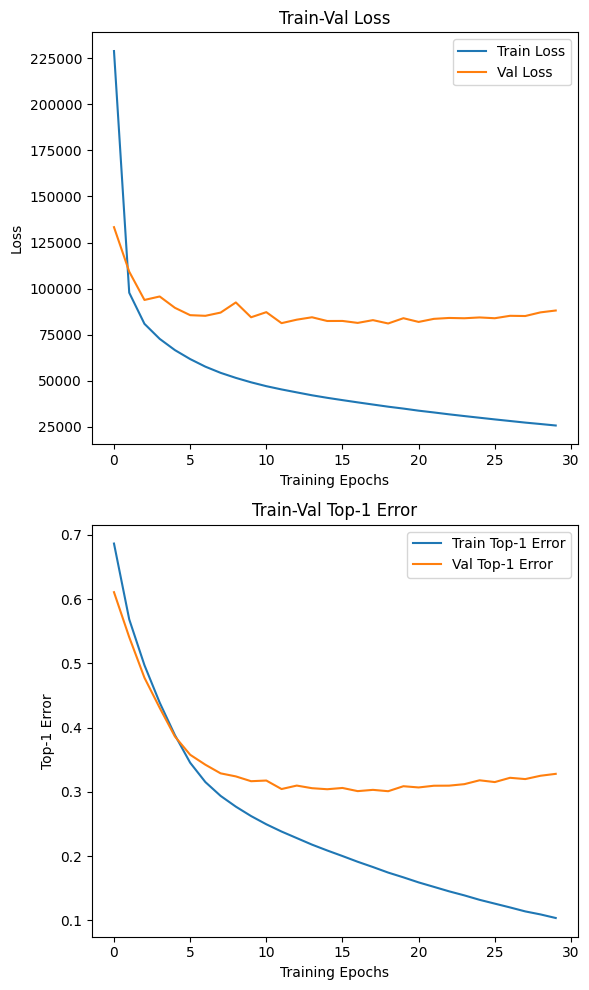

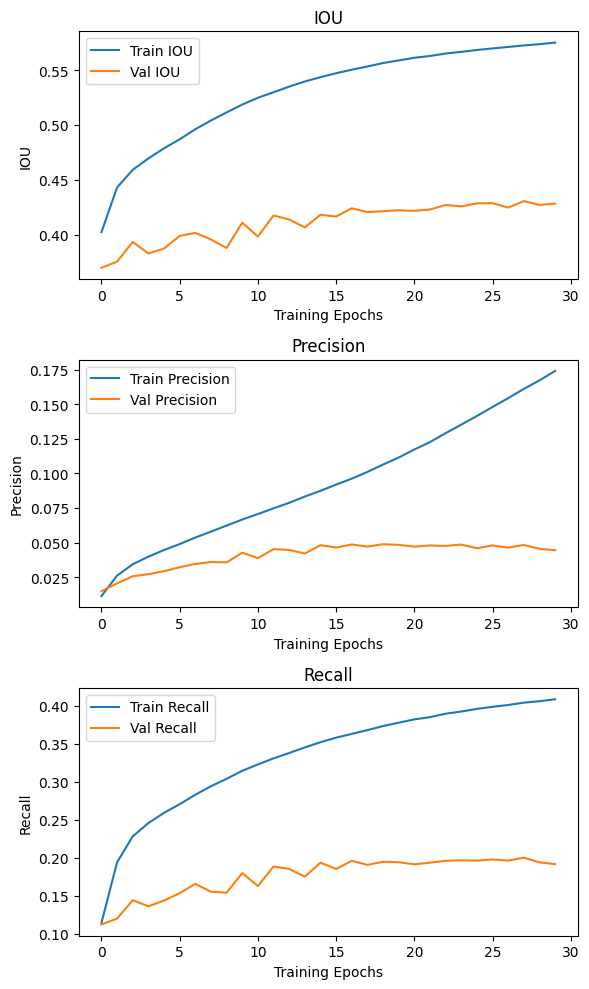

In [14]:
import numpy as np
import matplotlib.pyplot as plt
#histroy는 [train, test] 순임
#KPI는 [iou, precision, recall, top1_error] 순임
np_his_loss = np.array(his_loss)
np_his_KPI = np.array(his_KPI)

# his_loss에서 손실 데이터 추출
train_loss, val_loss = np_his_loss[..., 0], np_his_loss[..., 1]

# his_KPI에서 각 성능 지표 추출
train_iou, val_iou = np_his_KPI[..., 0, 0], np_his_KPI[..., 1, 0]
train_precision, val_precision = np_his_KPI[..., 0, 1], np_his_KPI[..., 1, 1]
train_recall, val_recall = np_his_KPI[..., 0, 2], np_his_KPI[..., 1, 2]
train_top1_errors, val_top1_errors = np_his_KPI[..., 0, 3], np_his_KPI[..., 1, 3]

# 1x2 로 그래프 그리기
plt.figure(figsize=(6, 10))

# Train-Val Loss
plt.subplot(2, 1, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train-Val Loss')

# Train-Val Top-1 Error
plt.subplot(2, 1, 2)
plt.plot(train_top1_errors, label='Train Top-1 Error')
plt.plot(val_top1_errors, label='Val Top-1 Error')
plt.xlabel('Training Epochs')
plt.ylabel('Top-1 Error')
plt.legend()
plt.title('Train-Val Top-1 Error')

plt.tight_layout()
plt.show()

# 1x3로 그래프 그리기
plt.figure(figsize=(6, 10))

# IOU
plt.subplot(3, 1, 1)
plt.plot(train_iou, label='Train IOU')
plt.plot(val_iou, label='Val IOU')
plt.xlabel('Training Epochs')
plt.ylabel('IOU')
plt.legend()
plt.title('IOU')

# Precision
plt.subplot(3, 1, 2)
plt.plot(train_precision, label='Train Precision')
plt.plot(val_precision, label='Val Precision')
plt.xlabel('Training Epochs')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision')

# Recall
plt.subplot(3, 1, 3)
plt.plot(train_recall, label='Train Recall')
plt.plot(val_recall, label='Val Recall')
plt.xlabel('Training Epochs')
plt.ylabel('Recall')
plt.legend()
plt.title('Recall')

plt.tight_layout()
plt.show()

In [15]:
torch.cuda.empty_cache()